In [94]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/learning rate tuning')

Mounted at /content/drive/


In [2]:
!pip install ultralytics

In [3]:
# Imports
import cv2
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTConfig


In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'Device name: {torch.cuda.get_device_name(0)}')

detector = YOLO('yolov8n.pt')
detector.to(device)

NUM_CLASSES = 12
model_name = 'google/vit-base-patch16-224'

Using device: cpu
CUDA available: False


In [ ]:
from safetensors.torch import load_file


config = ViTConfig.from_pretrained('/content/drive/MyDrive/learning rate tuning/config.json')
classifier = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    trust_remote_code=True 
)
classifier.to(device)
classifier.eval()

state_dict = load_file('/content/drive/MyDrive/learning rate tuning/best_model.safetensors')

classifier.load_state_dict(state_dict, strict=False)
classifier.to(device)
classifier.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [ ]:
import numpy as np
def classify_image(image_path):
    frame = Image.open(image_path).convert('RGB') # Convert image to RGB
    # image_tensor = transform(image).unsqueeze(0).to(device)
    frame_np = np.array(frame)
    # OpenCV expects BGR, so convert color space
    frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
    results = detector(frame)[0]  

    for result in results.boxes: # Iterate through the boxes object
        xyxy = result.xyxy[0] # Extract the bounding box coordinates
        x1, y1, x2, y2 = map(int, xyxy)  
        conf = result.conf.item() 


        person_img = frame.crop((x1,y1,x2,y2))
        if person_img.size == 0:
            continue  

        person_img = np.array(person_img)
        person_img_pil = Image.fromarray(cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB))
        input_tensor = transform(person_img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = classifier(input_tensor)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=1).item()
            print(predicted_class)
            
        label = predicted_class

        cv2.rectangle(frame_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_np, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(frame_np, cv2.COLOR_BGR2RGB)) # Convert back to RGB for display
        plt.show()




0: 416x640 2 persons, 171.1ms
Speed: 4.7ms preprocess, 171.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
2


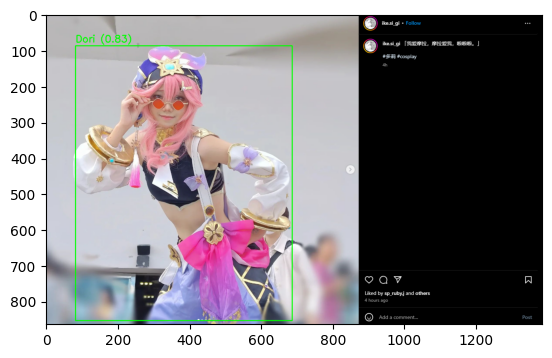

2


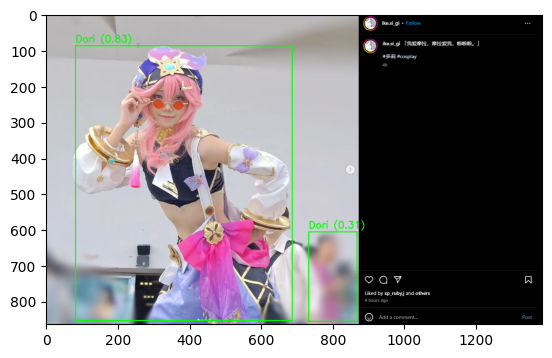

In [99]:
import matplotlib.pyplot as plt # Import matplotlib
import matplotlib.patches as patches # Import patches
image_path = '/content/drive/MyDrive/learning rate tuning/ig_dori.png'
classify_image(image_path)
